<a href="https://colab.research.google.com/github/noahcorona/ucsb-ece-160/blob/main/Mini_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# **Noah Corona**

## **Mini Project 2:** *Tempo Estimation for Musical Audio Signals*

</center>

---

## **Goals**

    1.   Develop a system that takes as input an audio file and outputs the beats per minute, or BPM, of the audio. 
    2.   Tune system parameters to obtain acceptable results on test data
    3.   Explain implementations and design choices

## **Sections**


    1.   Setup
    2.   Writing an STFT method
    3.   Explain various design choices
    4.   Attributions




# **Setup**

## **Setup: Google Drive**

In [144]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Setup: Imports**

In [145]:
!pip install essentia
import warnings
import os
import math
from pprint import pprint
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from matplotlib import cycler
import numpy as np
from essentia.standard import MonoLoader
from scipy.signal import stft as demo_stft
from scipy import interpolate
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Setup: Constants**

In [146]:
"""
    Sample rate = 44.1kHz
"""
sample_rate, sample_freq = 44100, float(1/44100)

"""
    Graph configuration
"""
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.prop_cycle'] = cycler(color=['mediumpurple', "0.7"])
axis_title_size = 20

"""
    Audio data source
"""
media_dir = "/content/drive/Shared drives/ECE160-Visell-2022/Media Files/tempo_dataFolder/"
file_list = [file[:-4] for file in os.listdir(media_dir) if file.endswith('.wav')]

 ## **Setup: Data extraction**




In [147]:
"""
    - Create dictionary for audio data
    - Extract file list from Google Drive tempo data folder
    - For each audio file
        - Extract mono sample with essentia MonoLoader
        - Extract 'true' BPM data from bpm file
        - Append data to *audio_data* dictionary
"""

# Dictionary storing all data for the program
audio_data = dict()

# Loop through all files from data source
for filename in file_list:
    # Initialize sample dict
    audio_data[filename] = dict()
    # Get file paths
    beat_file_filepath = media_dir + filename + ' beat.bpm'
    audio_file_filepath = media_dir + '/' + filename + '.wav'
    # Load bpm data from file
    f = open(beat_file_filepath)
    audio_data[filename]['real_bpm'] = float(f.read())
    f.close()
    # Load audio data from file
    loader = MonoLoader(filename=audio_file_filepath)
    audio = loader()
    audio_data[filename]['audio'] = np.array(audio, dtype=float)

# **Optional:** *Audio Sample Visualization*

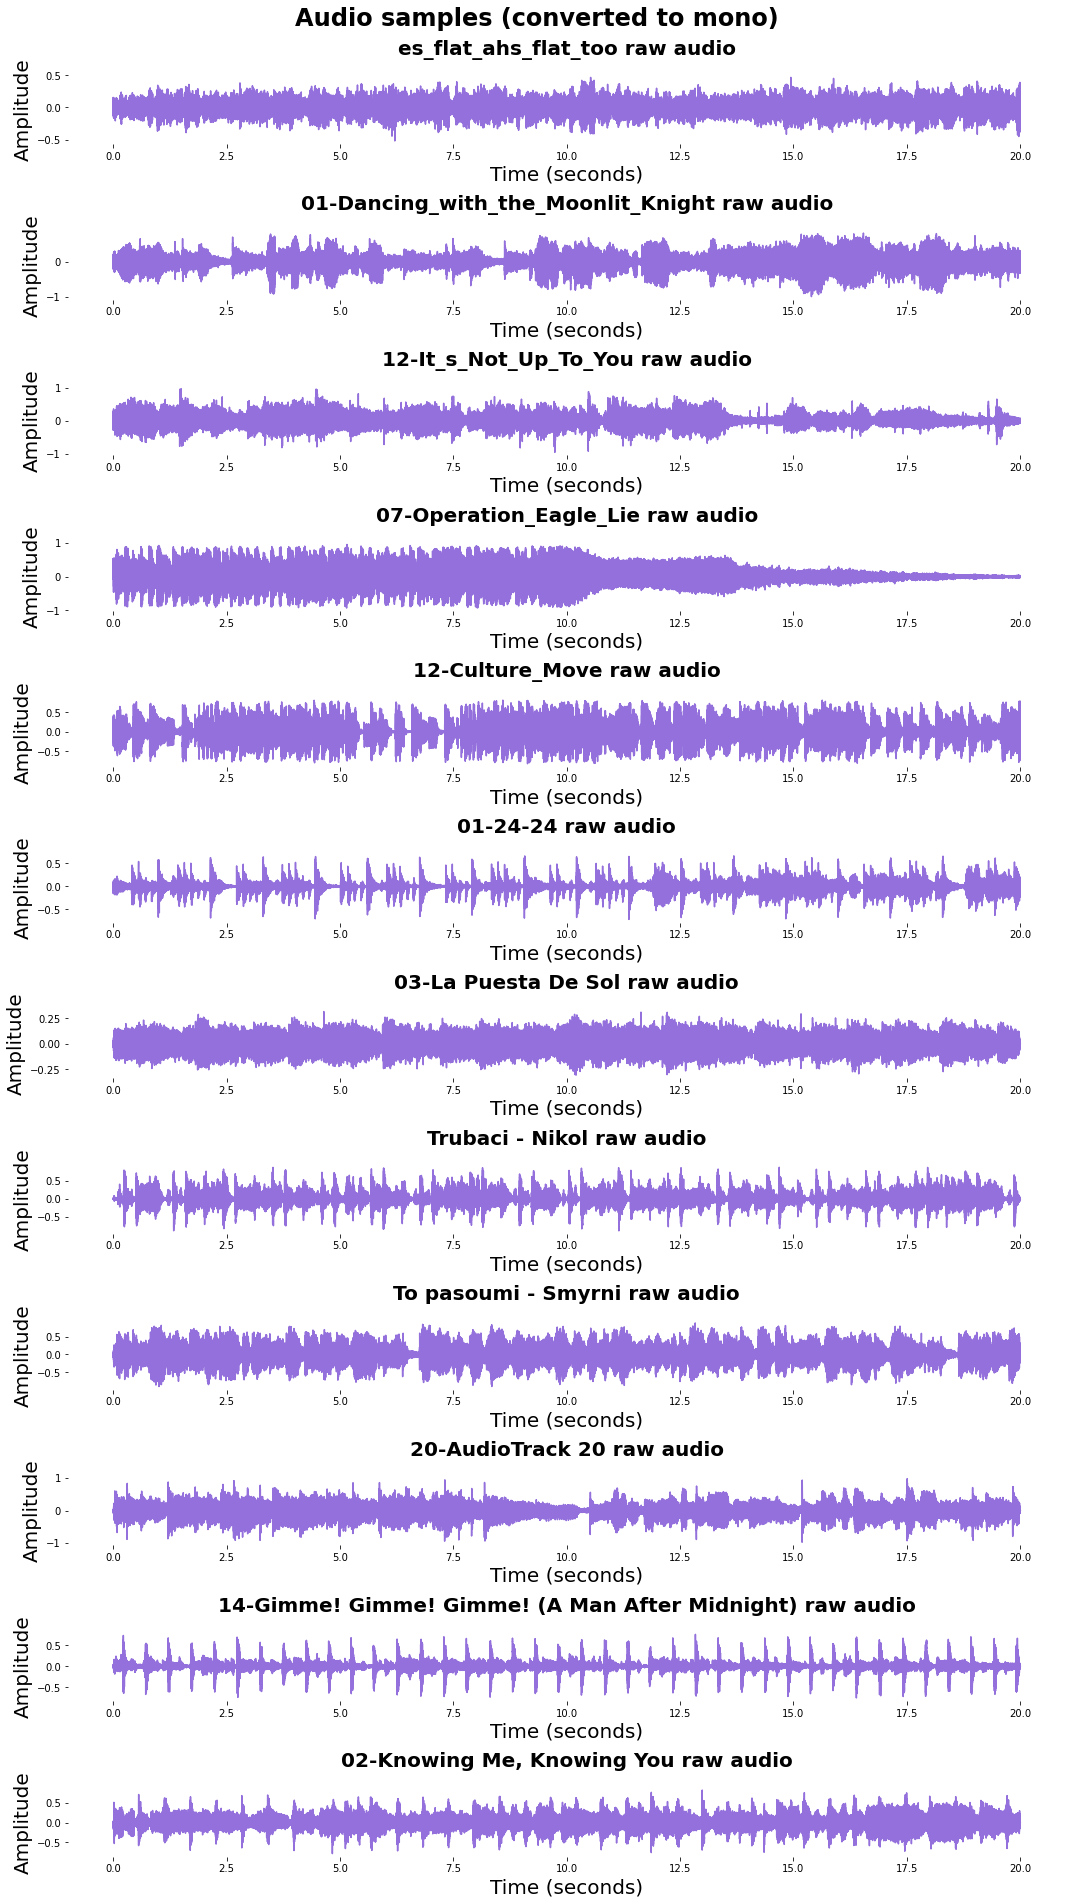

In [148]:
audio_samples = audio_data.items()
num_samples = len(audio_data.items())
num_cols = 1
num_rows = int(num_samples)

fig = plt.figure(figsize=(15, 30), frameon=False)
plt.suptitle('Audio samples (converted to mono)', fontsize=24, fontweight='bold')
plt.axis('off')
for idx, (name, audio_sample) in enumerate(audio_data.items()):
    current_plot = idx * num_cols
    audio = audio_sample['audio']
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 1)
    ax.set_title(name + ' raw audio')
    ax.set_xlabel('Time (seconds)', fontsize=axis_title_size)
    ax.set_ylabel('Amplitude', fontsize=axis_title_size)
    time_steps = np.linspace(0, audio.size/sample_rate, audio.size)
    ax.plot(time_steps, audio)
    ax.axis('auto')

fig.tight_layout(rect=[0, 0.1, 1, 0.97])
fig.show()
print('\n\n\n')

# **Step 1:** *Writing an STFT Method*

## **Purpose**

    Digital audio recordings are not perfect, and our samples are no exception.
    The samples were recorded with some level of background noise, and likely
    had less-than-ideal recording quality to begin with. To help discern
    different types of audio events (e.g. clapping, hitting a snare, strumming
    a guitar) in the signal, we apply the short-time Fourier transform, or
    STFT. The STFT gives us information about how different frequencies present
    in the signal change over time. So, rather than just looking at the overall
    audio level to detect a beat. 

    Some of the files in our test set contain more artifacts than others, but I 
    generally had no problem with their quality in completing the project. 

## **Implementation Summary**

    The implementation I used for the STFT is relatively simple. It slides a 
    window over the sample, padding the window and audio with zeros in the 
    process. For each window, it computes the FFT of the overlapping area 
    (using a Hann window of length 1024) and appends it to the result. My 
    implementation fixes the hop size to one half the window/segment size for 
    simplicity's sake. 

## **Results Summary**

    My STFT function produced a clear spectrogram. No pre- or post-processing 
    was necessary to obtain usable results. After experimenting with a variety
    of window sizes (all with hop size of half the window size), I found that 
    1024 provided a good balance between performance and results. Smaller FFT 
    sizes increased the intensity of the STFT plots, but did not help overall 
    in tempo estimation. 


### **Writing an STFT method: Constants**

In [149]:
# STFT parameters
segment_size = 1024
hop_size = 512
window = np.hanning(segment_size)

### **Writing an STFT method: Helper functions**

In [150]:
"""
_to_db: Takes the magnitude of an STFT result and scales it to decibals
    - Params: 
        stft: 2D ndarray (the stft result)
    - Returns:
        The array scaled to decibals
"""
def _to_db(stft):
    _stft = 20 * np.log10(np.abs(stft))
    _stft = np.clip(_stft, -40, 160)
    return _stft


"""
_stft: Takes a signal and computes the short-time Fourier transform
    - Params:
        audio: 1D (mono) audio signal
    - Returns: 
        2D ndarray (the stft) with the y-axis representing frequency magnitude and the x-axis representing the bin index
    - Implementation
        - Calculate the number of segments based on window size and sample size
        - Pad the audio with with length of the FFT (necessary for the last hop)
        - Calculate FFT of window using NumPy, and add result to audio data dictionary
"""
def _stft(audio):
    # Use Hann windowing
    window = np.hanning(segment_size)
    # Pad the audio sample
    padded_audio = np.concatenate((audio, np.zeros(segment_size)))
    num_segments = int(math.ceil(audio.size / float(hop_size)))
    stft = np.empty(shape=(segment_size, num_segments), dtype=float)
    for segment_index in range(num_segments):
        segment_start = segment_index * hop_size
        # Apply windowing and pad segment
        segment = window * padded_audio[segment_start:segment_start + segment_size]
        segment_padded = np.append(segment, np.zeros(segment_size))
        # Compute FFT on padded segment
        segment_fft = np.fft.fft(segment_padded)
        # Truncate result to appropriate size
        stft[:, segment_index] = segment_fft[:segment_size]
    return stft

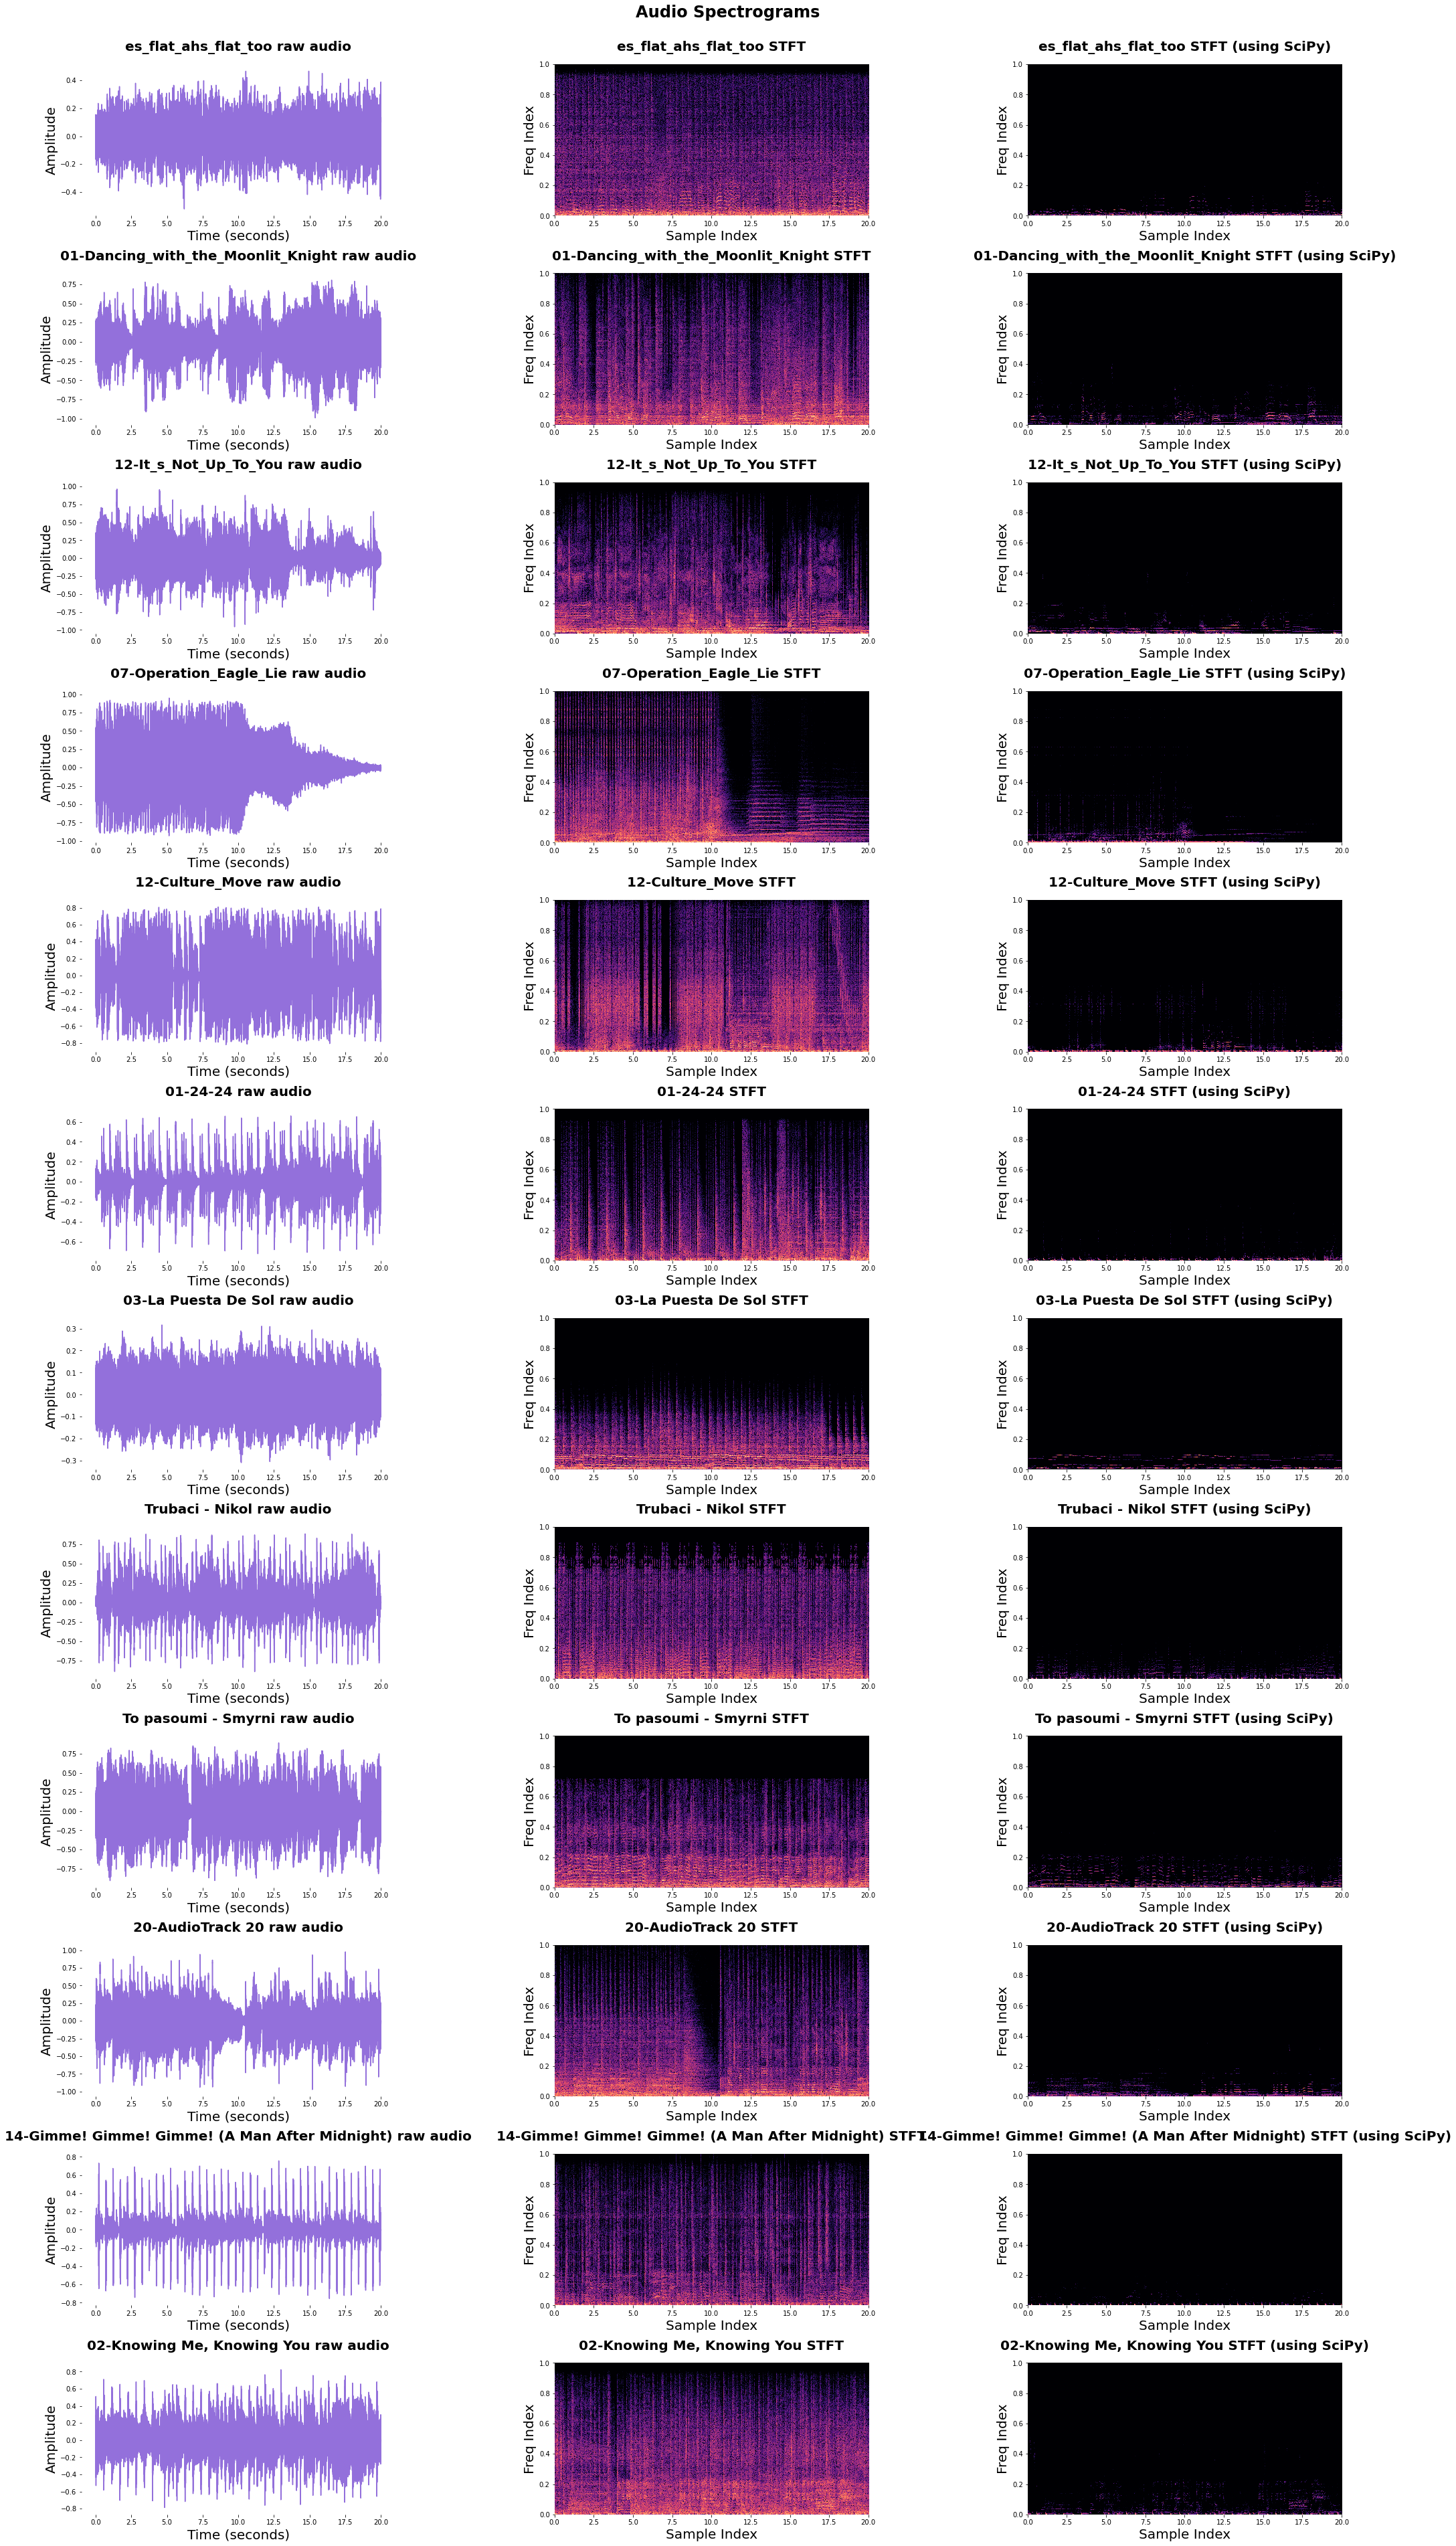

In [151]:
"""
    1. Compute STFT using my function, and then scipy.signal.stft
"""
for name, audio_sample in audio_data.items():
    stft = _stft(audio_sample['audio'])
    # Convert results to dB, update audio data dictionary
    audio_data[name]['stft'] = _to_db(stft)
    _, _, scipy_stft = demo_stft(audio_sample['audio'], 
                            fs=sample_freq,
                            nfft=segment_size,
                            nperseg=segment_size,
                            noverlap=int(segment_size*0.5))
    # Convert results to dB, update audio data dictionary
    audio_data[name]['scipy_stft'] = _to_db(scipy_stft)

"""
2. Graph the comparisons alongside raw audio for comparison
"""

fig = plt.figure(figsize=(30, 60), frameon=False)
plt.suptitle('Audio Spectrograms', fontsize=24, fontweight='bold')
plt.axis('off')
num_cols = 3

for idx, (name, audio_sample) in enumerate(audio_data.items()):
    current_plot = idx * num_cols
    audio = audio_sample['audio']
    STFT = audio_sample['stft']
    scipy_STFT = audio_sample['scipy_stft']

    # Plot raw audio signal
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 1)
    ax.set_title(name + ' raw audio')
    ax.set_xlabel('Time (seconds)', fontsize=axis_title_size)
    ax.set_ylabel('Amplitude', fontsize=axis_title_size)
    time_steps = np.linspace(0, audio.size/sample_rate, audio.size)
    ax.plot(time_steps, audio)
    ax.axis('auto')
    # Graph my STFT
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 2)
    ax.set_title(name + ' STFT')
    ax.set_xlabel('Sample Index', fontsize=axis_title_size)
    ax.set_ylabel('Freq Index', fontsize=axis_title_size)
    ax.imshow(STFT, origin='lower', cmap='magma', interpolation='nearest', aspect='auto',
              extent=[0, audio.size / sample_rate, 0, 1])
    ax.axis('auto')
    # Graph SciPy STFT
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 3)
    ax.set_title(name + ' STFT (using SciPy)')
    ax.set_xlabel('Sample Index', fontsize=axis_title_size)
    ax.set_ylabel('Freq Index', fontsize=axis_title_size)
    ax.imshow(scipy_STFT, origin='lower', cmap='magma', interpolation='nearest', aspect='auto',
              extent=[0, audio.size / sample_rate, 0, 1])
    ax.axis('auto')

fig.tight_layout(rect=[0, 0.1, 1, 0.97])
fig.show()

# **Step 2:** *STFT → Novelty Function*

## **Purpose**

    The purpose of a novelty function is to provide insight into how an audio signal changes with time. When a 'novelty' event occurs, the novelty function should represent the event with a peak. In some cases, it is beneficial to optimize the peaking behavior of the novelty function; this can be done through methods such as background subtraction, signal amplification, etc. 


    The STFT naturally paints a picture of how (the frequency content of) a signal varies over time. This makes it a great candidate for building a novelty function, and this is how I will proceed. 


## **Implementation Summary**

    a

## **Results Summary**

    However, experimentally, I had poor results when performing these methods. 



## **Novelty Function: Helper functions**

In [152]:
"""
First-order discrete derivative of a signal
"""
def _derivative(x):
    return np.diff(x, n=1)

"""
Half-wave rectification of a signal
"""
def _rectify(x):
    x[x < 0] = 0
    return x

"""
Summation of a 2D array column-wise
"""
def _sum_columns(x):
    return np.sum(x, axis=0)

"""
Novelty function helper routine
    1. Take first-order derivative dy = (d_freq/d_sample_index)
    2. Rectify the derivative
    3. Sum the derivative over the frequency axis
    4. Append a 0 for the element removed by first-order derivative
"""
def _novelty(stft):
    # First order discrete derivative of the frequency 
    dy = _derivative(stft)
    # Rectify derivative
    dy = _rectify(dy)
    # Sum the derivative over the frequency axis
    tempogram = _sum_columns(dy)
    # Append a 0 for element removed by derivative
    tempogram = np.concatenate((tempogram, np.array([0.0])))
    tempogram /= tempogram.max(axis=0)
    tempogram_sample_freq = sample_freq/hop_size
    return tempogram, tempogram_sample_freq

## **Novelty Function: Computation and Visualization**



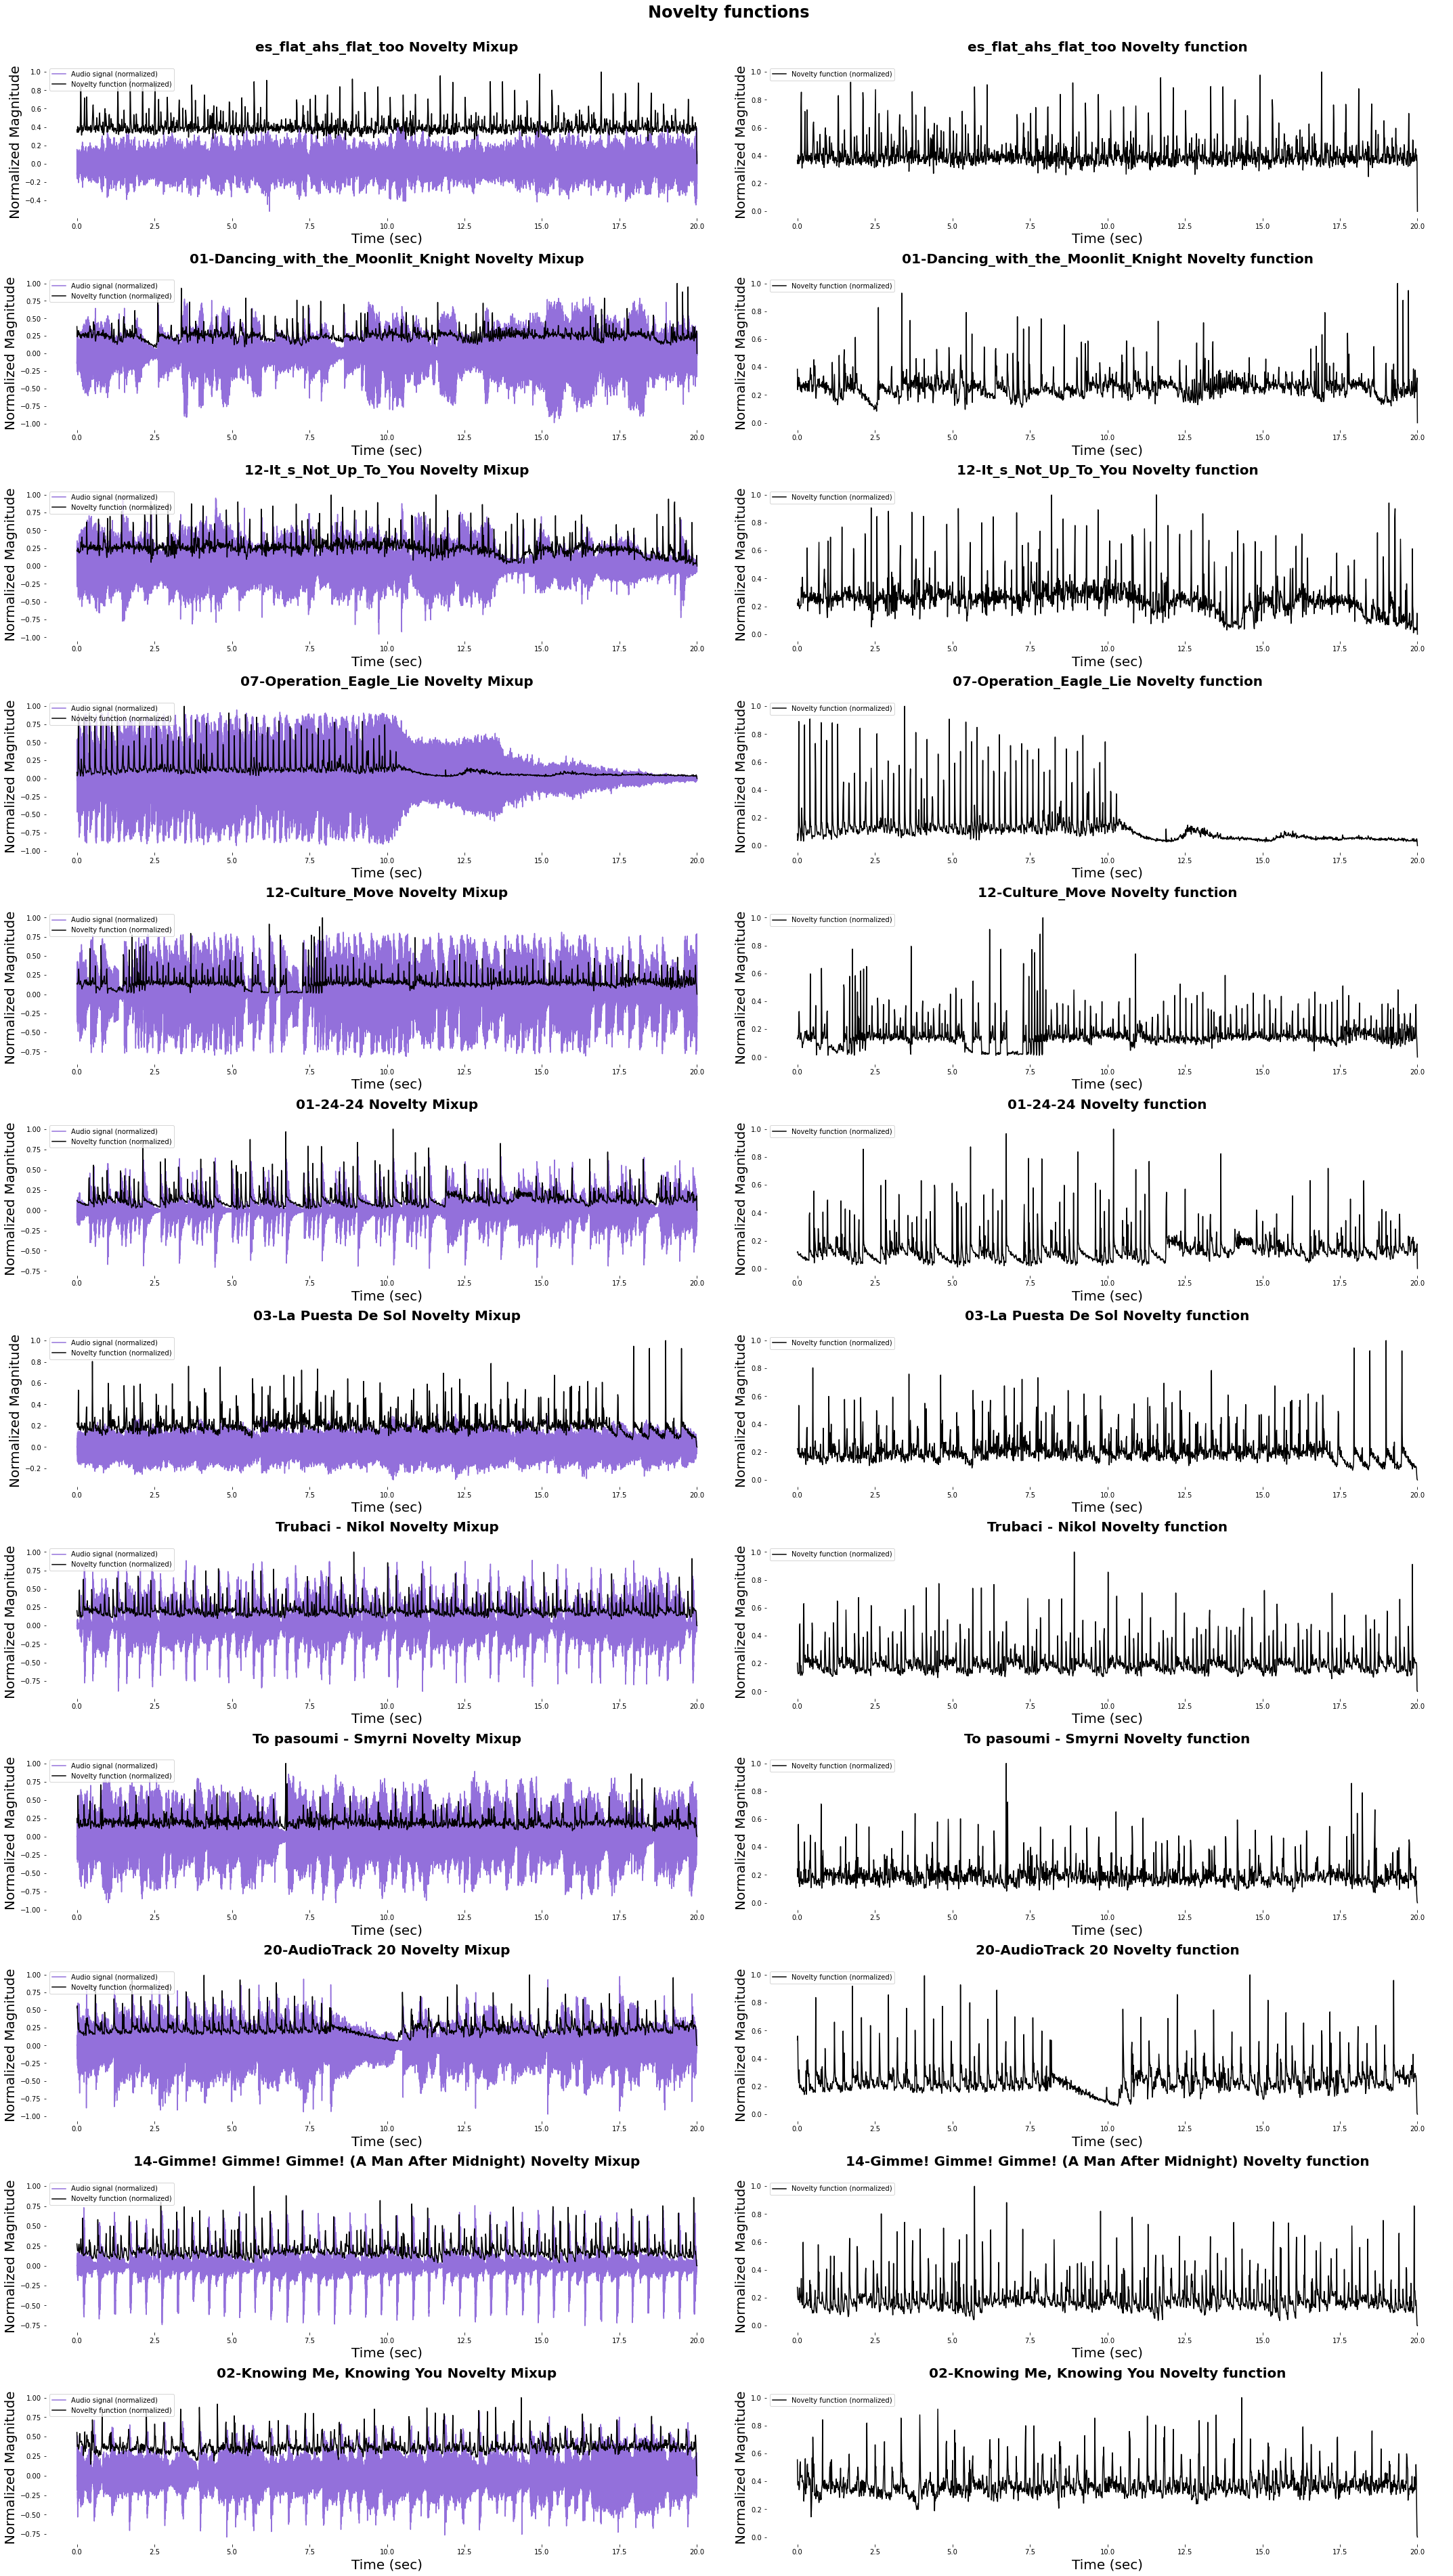

In [153]:
"""
Routine for computing and visualizing the novelty function
    - Uses novelty spectrum helper function to create novelty curve from an STFT result
    - Output: A (num_filesx2) grid
        - Left column: Raw audio in purple, overlayed with the novelty function in block
        - Right column: Novelty function alone
"""

fig = plt.figure(figsize=(30, 60), frameon=False)
plt.suptitle('Novelty functions', fontsize=24, fontweight='bold')
plt.axis('off')
num_cols = 2

for idx, (name, audio_sample) in enumerate(audio_data.items()):
    current_plot = idx * num_cols

    # Get the original audio sample, normalize
    audio = audio_sample['audio']
    # Generate audio sample timesteps
    len_bits = audio.size
    len_seconds = len_bits/sample_rate
    audio_t = np.linspace(0, len_seconds, len_bits)

    # Get audio stft from dictionary
    STFT = audio_sample['stft']
    # Extract novelty function from STFT
    novelty, novelty_sample_freq = _novelty(STFT)

    # Interpolate up to sample size of audio for viewing on graph
    len_novelty = novelty.size
    interp = interpolate.interp1d(np.arange(len_novelty), novelty)
    novelty_interp = interp(np.linspace(0, len_novelty - 1, len_bits))
    # Plot audio in purple, novelty function in black
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 1)
    ax.set_title(name + ' Novelty Mixup')
    ax.set_xlabel('Time (sec)', fontsize=axis_title_size)
    ax.set_ylabel('Normalized Magnitude', fontsize=axis_title_size)
    ax.plot(audio_t, audio, color='mediumpurple', label='Audio signal (normalized)')
    ax.plot(audio_t, novelty_interp, color='black', label='Novelty function (normalized)')
    plt.legend(loc="upper left")
    ax.axis('auto')
    # Plot novelty function in puple
    novelty_t = np.linspace(0, audio.size/sample_rate, len(novelty))
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 2)
    ax.set_title(name + ' Novelty function')
    ax.set_xlabel('Time (sec)', fontsize=axis_title_size)
    ax.set_ylabel('Normalized Magnitude', fontsize=axis_title_size)
    ax.plot(novelty_t, novelty, color='black', label='Novelty function (normalized)')
    plt.legend(loc="upper left")
    ax.axis('auto')

    # Update audio data dictionary
    audio_data[name]['novelty'] = novelty
    audio_data[name]['novelty_sample_freq'] = novelty_sample_freq
    audio_data[name]['novelty_interp'] = novelty_interp
    

fig.tight_layout(rect=[0, 0.1, 1, 0.97])
fig.show()
print('\n\n\n')

# **Step 3:** *Novelty Function → Fourier Tempogram*

## **Purpose**

    The purpose of a novelty function is to provide insight into how an audio 
    signal changes with time. When a 'novelty' event occurs, the novelty 
    function should represent the event with a peak. In some cases, it is 
    beneficial to optimize the peaking behavior of the novelty function; this 
    can be done through methods such as background subtraction, signal 
    amplification, etc. 


    The STFT naturally paints a picture of how (the frequency content of) a 
    signal varies over time. This makes it a great candidate for building a 
    novelty function, and this is how I will proceed. 


## **Implementation Summary**

    The routine here looks a lot like the routine for the STFT, but with an 
    exponential step in the middle. It involved padding the window, padding the 
    sample, convolution, etc,. but with a complex exponential. The exponential 
    relates the BPM to the coefficients in the exponential function. The 
    novelty function serves as the constant outside the exponential. 

## **Results Summary**

    The result is a plot with BPM on the vertical axis and time on the 
    horizontal. The color profile demonstrates the intensity at a given BPM 
    correctly, as per the sample data labels. 
    
    I was able to try a variety of STFT configurations for the tempogram, as 
    well as different settings for the tempogram, including hopping/segment 
    size (both tempogram and STFT) and STFT FFT size. After finding the best 
    parameters to generate the graph from the samples, the results were more 
    than satisfactory. A STFT of with FFT and window size 1024 and hope size of
    512 generated clear results on the tempogram. 

## **Fourier Tempogram: Constants**

In [154]:
"""
bpm_spacing: Spacing between values of BPM range. 

    - Affects the resolution of the BPM computation, as well as the tempograph that is rendered. 
    - Larger spacing <=> shorter compute time
    - Smaller spacing <=> longer compute time
"""
bpm_spacing = 1


"""
bpm_limit: The upper limit on BPM values to generate a tempogram for. 
           Eliminates unnecessary computation on bins we are not interested in. 

    - For this project, the test audio set ranges from ~70 to ~160 BPM. Appropriately, the floor is set to 60 BPM (bpm_bias) and the bpm_limit to 170 BPM. 
    - Affects the output size of the graph. In our [60, 170] range example, this yields a (110xtime_samples) ndarray. 
"""
bpm_limit = 170


"""
Tempogram segment size

    - Affects the timescale of the resulting tempogram
"""
tempogram_segment_size = 250


"""
Tempogram hop size: Decreasing this positively affects the resolution of the tempogram. 

    - Through experimental testing, I found that for many configurations the optimal hop size is 5
"""
tempogram_hop_size = 10

## **Fourier Tempogram: Helper function**

In [155]:
bpm_bins = np.arange(0, bpm_limit, bpm_spacing)
num_bpm_bins = len(bpm_bins)

def _tempogram(_novelty, novelty_sample_freq):
    window = np.hanning(tempogram_segment_size)
    padding = np.zeros(tempogram_segment_size // 2)
    padded_size = 2 * (tempogram_segment_size // 2) + novelty.size
    _novelty = np.concatenate((padding, novelty, padding))
    t = np.arange(padded_size)
    num_segments = int(np.floor(padded_size - tempogram_segment_size) / tempogram_hop_size) + 1

    # Initialize tempogram array
    tempogram = np.zeros((num_segments, num_bpm_bins))
    # Iterative over all BPM values we would like to analyze
    for bpm_idx in range(num_bpm_bins):
        novelty_exp = _novelty * np.exp(-2 * 1j * np.pi * t * bpm_bins[bpm_idx] / novelty_sample_freq / 60)
        for segment_index in range(num_segments):
            segment_start = segment_index * tempogram_hop_size
            segment = novelty_exp[segment_start:segment_start + tempogram_segment_size]
            tempogram[segment_index, bpm_idx] = np.sum(window * segment)
    # Take magnitudes
    tempogram = np.abs(tempogram)
    return tempogram

## **Fourier Tempogram: Computation and Visualization**

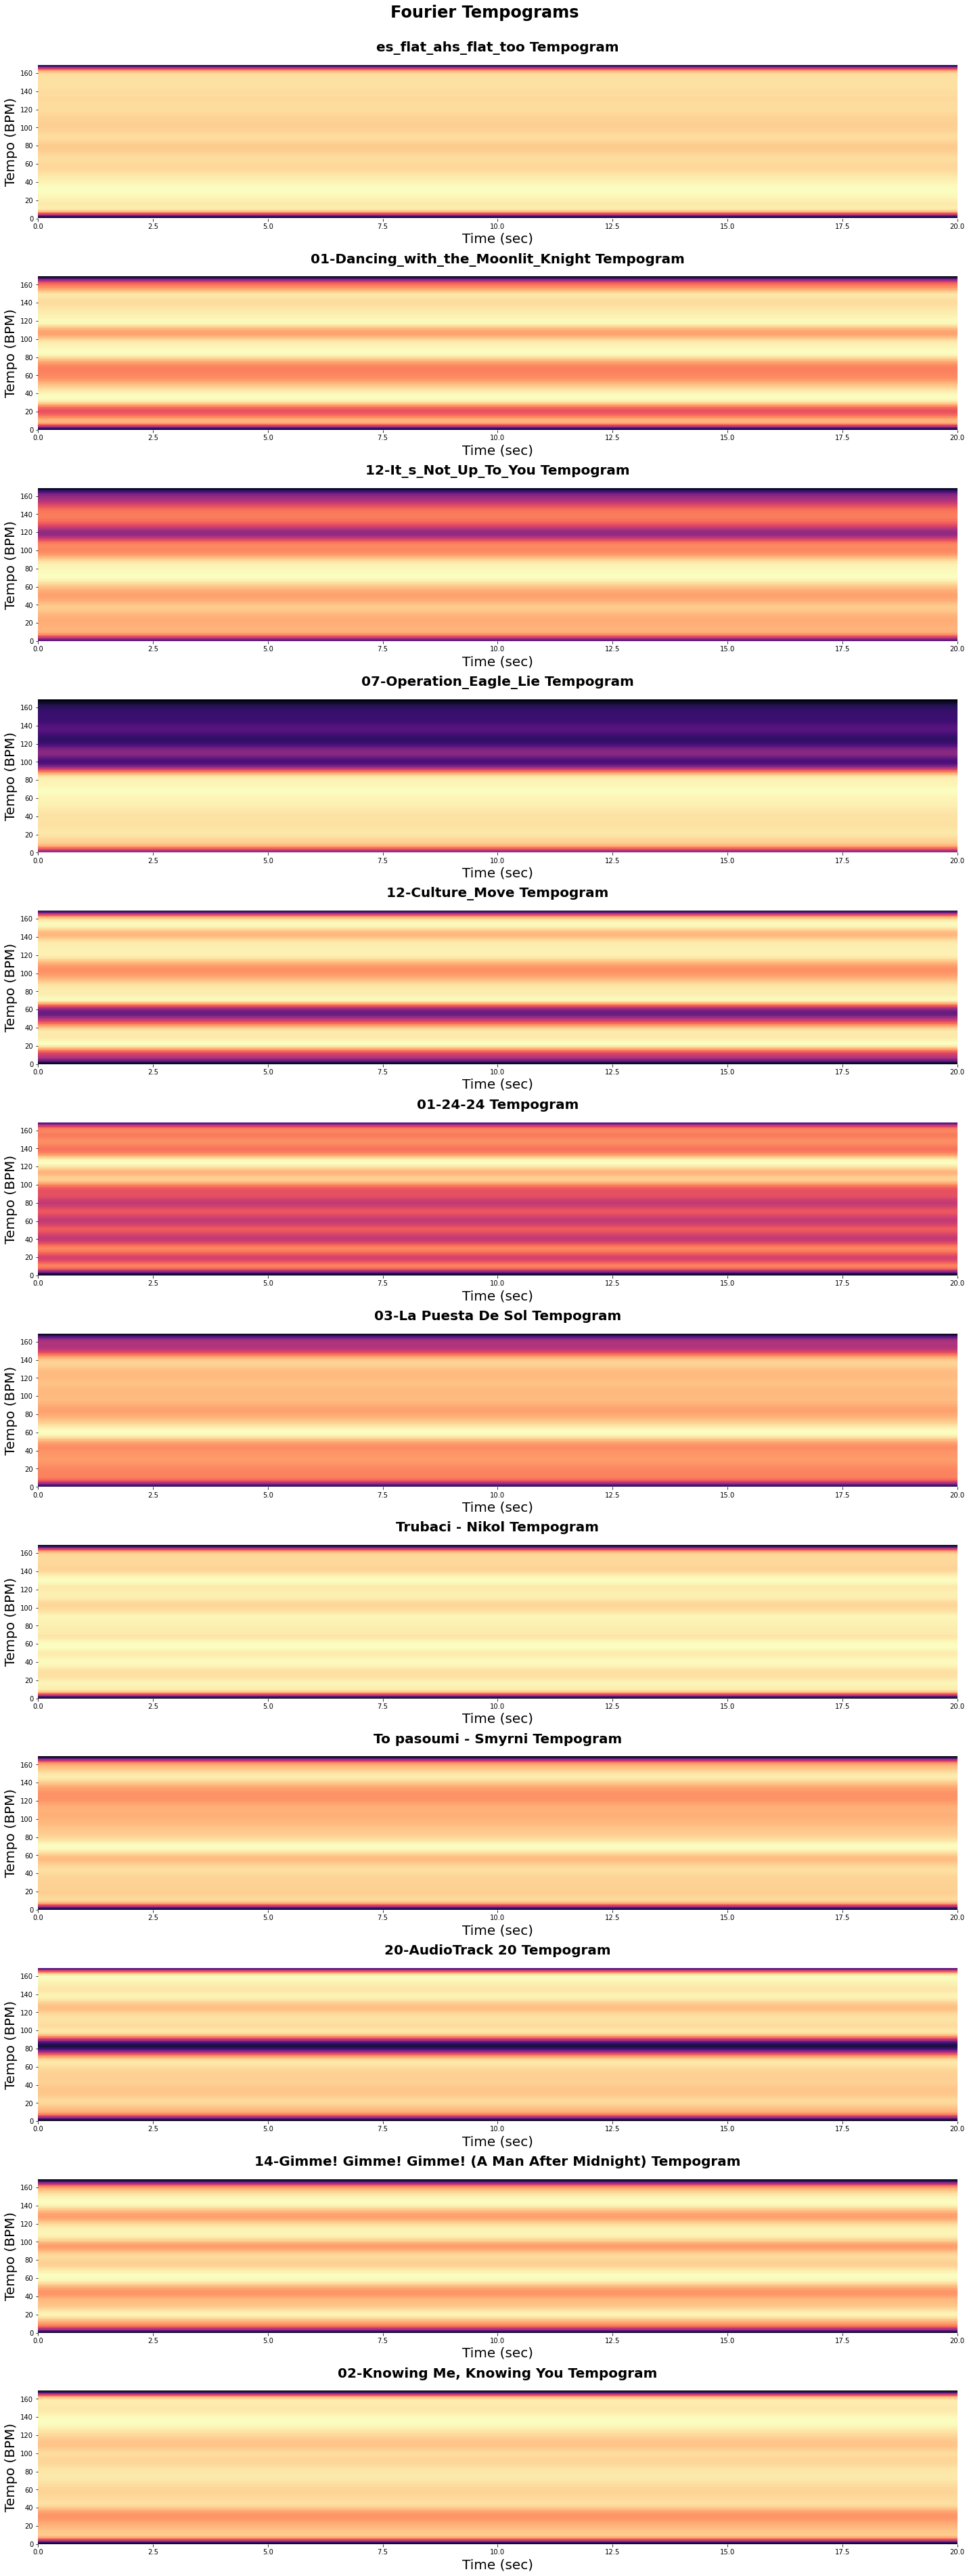

In [156]:
fig = plt.figure(figsize=(15, 60), frameon=False)
plt.suptitle('Fourier Tempograms', fontsize=24, fontweight='bold')
plt.axis('off')
num_cols = 1

for idx, (name, audio_sample) in enumerate(audio_data.items()):
    # Get novelty function and new sample freq from dict
    novelty, novelty_sample_freq = audio_sample['novelty'], audio_sample['novelty_sample_freq']
    # Compute tempogram
    tempogram = _tempogram(novelty, novelty_sample_freq)
    # Normalize tempogram
    tempogram = tempogram / tempogram.max(axis=0)
    tempogram_time = np.linspace(0, audio_sample['audio'].size / sample_rate, tempogram.shape[0])
    audio_data[name]['tempogram'] = (tempogram, tempogram_time)

    # Plot Fourier Tempograms
    current_plot = idx * num_cols
    ax = fig.add_subplot(num_rows, num_cols, current_plot + 1)
    ax.set_title(name + ' Tempogram')
    ax.set_xlabel('Time (sec)', fontsize=axis_title_size)
    ax.set_ylabel('Tempo (BPM)', fontsize=axis_title_size)
    plt.imshow(tempogram, cmap='magma', origin='lower', interpolation='nearest', aspect='auto',
               extent=[0, max(tempogram_time), min(bpm_bins), max(bpm_bins)])
    ax.axis('auto')

fig.tight_layout(rect=[0, 0.1, 1, 0.97])
fig.show()
print('\n\n\n')

# **Step 4:** *Fourier Tempogram → BPM Estimation*

## **Purpose**

    The Fourier tempogram, as the name suggests, aids with visualizing the
    tempo of a signal. It shows the relationship between the likelihoods/
    (really, intensities) of each point being a particular BPM.  

    The STFT naturally paints a picture of how (the frequency content of)
    a signal varies over time. This makes it a great candidate for 
    building a novelty function, and this is how I will proceed. 


## **Implementation Summary**

    BPM Prediction algorithm:
        - For each segment compute the peak indexes (in BPM)
        - Then, average the peaks of the column
        - Repeat for all columns and then average the values for the final estimate of BPM

## **Results Summary**

    My results for this section were the least satsifactory - I was not able
    to finish converting the tempogram data to an accurate digital reading
    for the BPM. However, in the process of trying to calculate the result
    I successfully built a tool that helps visualize the BPM of a
    signal visually over time. 

### **BPM Estimation: Computation and Visualization**

In [157]:
for idx, (name, audio_sample) in enumerate(audio_data.items()):
    (tempogram, tempogram_time) = audio_data[name]['tempogram']
    num_segments_tempo = tempogram.shape[0]
    real_bpm = audio_data[name]['real_bpm']
    
    pred_bpm = 0.0
    for time_idx in range(num_segments_tempo):
        bpms = tempogram[time_idx, :]
        max_bpm_indices = np.argpartition(bpms, -20, axis=0)[-20:]
        max_bpm_indices = np.sort(max_bpm_indices)
        pred_bpm += np.average(max_bpm_indices)
    pred_bpm /= num_segments_tempo
    audio_data[name]['est_bpm'] = pred_bpm


names = list()
targets = list()
preds = list()
errors = list()

for name, audio_sample in audio_data.items():
    real_bpm = audio_sample['real_bpm']
    est_bpm = audio_sample['est_bpm']
    error_bpm = abs(real_bpm - est_bpm)
    est_bpm = int(est_bpm)
    real_bpm = int(real_bpm)
    error_bpm = int(error_bpm)
    names.append(name)
    preds.append(est_bpm)
    targets.append(real_bpm)
    errors.append(error_bpm)

table = PrettyTable()
table.add_column('Name', names)
table.add_column('Real BPM', targets)
table.add_column('Estimate BPM', preds)
table.add_column('Error (BPM)', errors)
    
print(table)

+------------------------------------------------+----------+--------------+-------------+
|                      Name                      | Real BPM | Estimate BPM | Error (BPM) |
+------------------------------------------------+----------+--------------+-------------+
|              es_flat_ahs_flat_too              |   151    |      36      |     115     |
|       01-Dancing_with_the_Moonlit_Knight       |    80    |      88      |      8      |
|             12-It_s_Not_Up_To_You              |    80    |      80      |      0      |
|             07-Operation_Eagle_Lie             |    81    |      73      |      8      |
|                12-Culture_Move                 |    83    |      29      |      53     |
|                    01-24-24                    |   104    |     129      |      25     |
|              03-La Puesta De Sol               |   116    |      66      |      50     |
|                Trubaci - Nikol                 |   110    |      64      |      46     |

# **Conclusion:** *Analysis and Reflection*

    I really ran out of time for this project! As I was completing the project, 
    I had time to write plenty of code comments/text boxes that explain my 
    implementations. However, I feel like my analysis is lacking given the 
    research I put in to get the project this far. I almost finished up, making
    it to the last step I had planned for the tempo estimator. 

    I was able to get an STFT function, novelty function, and to generate a 
    Fourier tempogram for the given samples. Where I fell short is using the 
    tempogram to accurately retrieve the sample's BPM. By eye, the process is 
    trivial. Doing this in Python took a fair amount of tinkering that I just 
    didn't have time before the due date. The following are methods I tried to 
    various degrees of success (at best, accurate to +/- 25 BPM on the 
    **worst** sample):

        Use numpy.argmax to find the peak indices across each column. The prominent 
        peaks represent strong candidates for BPM at that point in time. Then either
            - choose the lowest BPM peak
            - choose the highest BPM peak
            - choose the center-most BPM peak
            - average the top 0 < n < 10 peaks





<center>

# **Attributions**

**The following sources were used (outside of the textbook) in the process of finishing this project. All code written in this document is my own.**

---

[Librosa docs](https://librosa.org/doc/main/generated/librosa.feature.fourier_tempogram.html)

[audiolabs-erlangen.de](https:/https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S2_TempogramFourier.html/)

[Stack Overflow](https://stackoverflow.com/)

</center>